In [1]:
import os

import evaluate
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from datasets import DatasetDict, load_dataset, concatenate_datasets
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertModel,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)

In [2]:
INPUT_DIR = "."
OUTPUT_DIR = "./output/xlm-roberta-large"
CHECKPOINT = "joeddav/xlm-roberta-large-xnli"
CACHE_DIR = "./models"

In [3]:
# Load data
data = load_dataset(
    "csv",
    data_files=os.path.join(INPUT_DIR, "train.csv"),
    trust_remote_code=True,
    split="train",
)
data = data.train_test_split(0.2)

aug_data = load_dataset(
    "csv",
    data_files=os.path.join(INPUT_DIR, "translated.csv"),
    trust_remote_code=True,
    split="train",
)

train_data_with_aug = concatenate_datasets([data["train"], aug_data])
shuffled_dataset = train_data_with_aug.shuffle(seed=42)

data = DatasetDict(
    {
        "train": shuffled_dataset,
        "val": data["test"],
        "test": load_dataset(
            "csv",
            data_files=os.path.join(INPUT_DIR, "test.csv"),
            trust_remote_code=True,
            split="train",
        ),
    }
)


In [4]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3)

model

/usr/local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_fe

In [5]:
class CNNCls(nn.Module):
    def __init__(self):
        super(CNNCls, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=768, out_channels=256, kernel_size=3, padding=1
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


class CNN3Cls(nn.Module):
    def __init__(self):
        super(CNN3Cls, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=1024, out_channels=768, kernel_size=3, padding=1
        )
        self.conv2 = nn.Conv1d(
            in_channels=768, out_channels=512, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv1d(
            in_channels=512, out_channels=256, kernel_size=3, padding=1
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


class LSTMCls(nn.Module):
    def __init__(self):
        super(LSTMCls, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1024, hidden_size=256, num_layers=1, batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        # Typically, you might want to use the last hidden state for classification:
        last_hidden_state = output[:, -1, :]
        x = self.relu(last_hidden_state)
        x = self.dropout(x)
        x = self.fc(x)
        return x


class GRUCls(nn.Module):
    def __init__(self):
        super(GRUCls, self).__init__()
        self.gru = nn.GRU(
            input_size=1024, hidden_size=256, num_layers=1, batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # GRU的输出 (output, h_n)
        output, h_n = self.gru(x)  # output: (batch_size, seq_length, hidden_size)
        x = output[:, -1, :]
        x = self.relu(x)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x


class RNNCls(nn.Module):
    def __init__(self):
        super(RNNCls, self).__init__()
        self.rnn = nn.RNN(
            input_size=1024, hidden_size=256, num_layers=1, batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # RNN的输出包括 (output, h_n)
        output, h_n = self.rnn(x)  # output: (batch_size, seq_length, hidden_size)
        x = output[:, -1, :]
        x = self.relu(x)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x


class MultiheadAttentionCls(nn.Module):
    def __init__(self):
        super(MultiheadAttentionCls, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=1024, num_heads=8, batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(768, 3)

    def forward(self, x):
        # 假设x的形状是(batch_size, seq_length, embed_dim)
        # 多头注意力需要输入key, query, value，这里我们使用同一个x作为三者
        attn_output, _ = self.attention(x, x, x)
        # 取多头注意力输出的平均或者最后一个时间步的输出
        x = self.relu(attn_output)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class CustomBERTModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained(CHECKPOINT)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_labels),
        )
        self.loss = nn.CrossEntropyLoss()
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.dropout(output.pooler_output)
        logits = self.classifier(output)

        if labels is not None:
            loss = self.loss(logits.view(-1, self.num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}
        else:
            return logits

class ReluCls(nn.Module):
    def __init__(self):
        super(ReluCls, self).__init__()
        self.dense = nn.Linear(1024, 1024, bias=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1, inplace=False)
        self.out_proj = nn.Linear(1024, 3, bias=True)

    def forward(self, x):
        x = x[:, -1, :]
        x = self.dense(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

# model = CustomBERTModel(num_labels=3)
# model.classifier = ReluCls()
model_name = "XLM-RoBERTa-large-Linear"
model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_fe

In [6]:
def preprocess_data(batch):
    return tokenizer(batch['premise'], batch['hypothesis'], truncation=True, padding=True)


data = data.map(preprocess_data, batched=True)
data

Map:   0%|          | 0/105876 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'input_ids', 'attention_mask'],
        num_rows: 105876
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'input_ids', 'attention_mask'],
        num_rows: 5195
    })
})

In [7]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)


train_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "results"),
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    report_to=[],
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    save_steps=200,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=1,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    save_only_model=True,
)

# train_args

In [8]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(3)],
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,0.851500,0.316625,0.891089
400,0.494300,0.311086,0.893564
600,0.461800,0.269211,0.908828
800,0.410600,0.262155,0.912954
1000,0.416800,0.238197,0.913779
1200,0.388100,0.242702,0.921205
1400,0.376900,0.230733,0.922442
1600,0.330200,0.224192,0.922855
1800,0.322500,0.214152,0.929043
2000,0.327700,0.216026,0.927393


TrainOutput(global_step=6618, training_loss=0.2837728698580025, metrics={'train_runtime': 1837.8091, 'train_samples_per_second': 57.61, 'train_steps_per_second': 3.601, 'total_flos': 5.846386319202394e+16, 'train_loss': 0.2837728698580025, 'epoch': 1.0})

In [9]:
log = trainer.state.log_history
log

[{'loss': 0.8515,
  'grad_norm': 51.38053894042969,
  'learning_rate': 1.9410698096101544e-05,
  'epoch': 0.030220610456331218,
  'step': 200},
 {'eval_loss': 0.3166246712207794,
  'eval_accuracy': 0.8910891089108911,
  'eval_runtime': 6.6943,
  'eval_samples_per_second': 362.099,
  'eval_steps_per_second': 22.706,
  'epoch': 0.030220610456331218,
  'step': 200},
 {'loss': 0.4943,
  'grad_norm': 36.373374938964844,
  'learning_rate': 1.8806285886974917e-05,
  'epoch': 0.060441220912662436,
  'step': 400},
 {'eval_loss': 0.31108614802360535,
  'eval_accuracy': 0.8935643564356436,
  'eval_runtime': 6.6776,
  'eval_samples_per_second': 363.005,
  'eval_steps_per_second': 22.763,
  'epoch': 0.060441220912662436,
  'step': 400},
 {'loss': 0.4618,
  'grad_norm': 35.22843933105469,
  'learning_rate': 1.8201873677848293e-05,
  'epoch': 0.09066183136899365,
  'step': 600},
 {'eval_loss': 0.2692110240459442,
  'eval_accuracy': 0.9088283828382838,
  'eval_runtime': 6.3502,
  'eval_samples_per_sec

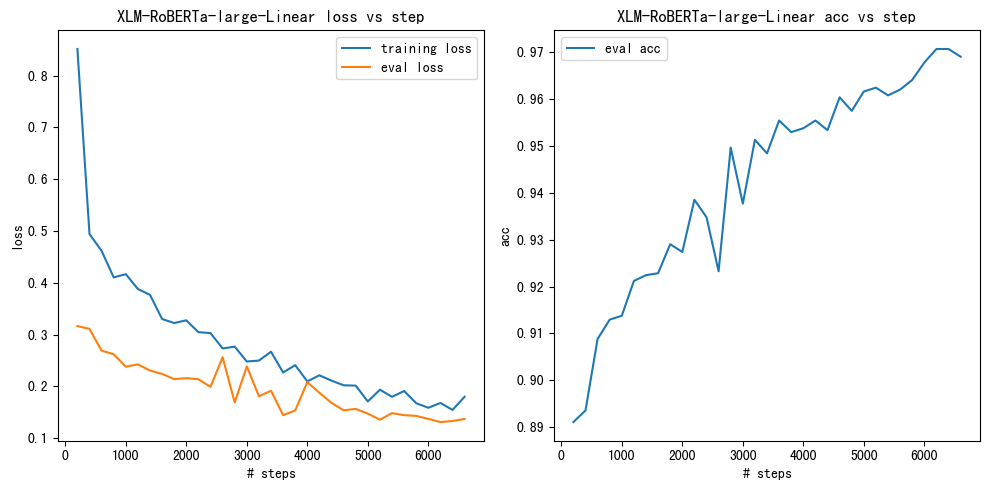

In [10]:
steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log["step"])
    train_loss.append(train_log["loss"])
    eval_loss.append(eval_log["eval_loss"])
    eval_acc.append(eval_log["eval_accuracy"])

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title(f"{model_name} loss vs step")
plt.xlabel("# steps")
plt.ylabel("loss")
plt.plot(steps, train_loss, label="training loss")
plt.plot(steps, eval_loss, label="eval loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title(f"{model_name} acc vs step")
plt.xlabel("# steps")
plt.ylabel("acc")
plt.plot(steps, eval_acc, label="eval acc")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Save steps, train_loss, eval_loss, eval_acc

with open(f"{model_name}_aug.json", "w") as f:
    json.dump(
        {
            "steps": steps,
            "train_loss": train_loss,
            "eval_loss": eval_loss,
            "eval_acc": eval_acc,
        },
        f,
        indent=4,
    )

In [ ]:
preds = trainer.predict(data["test"])
preds

In [ ]:
pd.DataFrame(
    {"id": data["test"]["id"], "prediction": np.argmax(preds.predictions, axis=1)}
).to_csv(os.path.join(OUTPUT_DIR, "submission.csv"), header=True, index=False)